# GPON Network visualizations - Part 1

This is the first of a short series of visualizations I've done in order to identify some "difficult to spot" conditions on GPON networks, which of course could be generalized to any network NEs as long as it makes sense.

## Today's visualization

The visualization that I'm showing you today is a annotated "heatmap" that would allow you to "see" the distribution of the average of the client quantity in each PON port as if you'd be seeing the OLT from the front:

![alt text](One_OLT_viz_1.png "Visualization example")

So, each column represents a slot of the OLT, each row represents a PON port, the number inside each cell is the average of the quantity of client in that PON port, and the color of each cell is a visual cue of how much "filled" is the OLT.

---
## Lack of public data

It is necessary that I address the fact that it would be nearly imposible to find a public dataset that contains the kind of information that I would need to make these visualizations (and the reason should be obvious to you), so in order to overcome this difficulty I will make a synthetic dataset, that, in no way pretends to be a reflection of real data, nor it will have a statistical support whatsoever, and the reason for that should be also obvious for you (if I ever state that the average of the number of customers in a OLT is X, that could mean that I am projecting some inside and private knowledge that I have into the data, and it would be troublesome for me in many ways), so I just will work with standard max numbers for this technology.

Now with that out of the way we can start to build our synthetic dataset, and because this is a GPON viz, I will make some synthetic OLT information with the following schema:

In [1]:
# Make all the imports needed

import pandas as pd
from itertools import product
from random import randint, choice
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(data=[[1,2,3,'model_A'],[5,6,7,'model_B']], columns=[['slot', 'port', 'client_qty', 'model']])
df

ImportError: cannot import name 'animation' from partially initialized module 'matplotlib' (most likely due to a circular import) (c:\Users\armedina\Anaconda3\envs\infraco\lib\site-packages\matplotlib\__init__.py)

In [ ]:
df = pd.DataFrame(data=[[1,2,3,'model_A'],[5,6,7,'model_B']], columns=[['slot', 'port', 'client_qty', 'model']])
df

,slot,port,client_qty,model
0,1,2,3,model_A
1,5,6,7,model_B


The data can come in any form: csv, xlsx, etc., and it should consist of at least the columns showed in the previous dataframe: 'slot', 'port', 'client_qty', 'model', and hopefuly each column name is self explanatory.

---

Now, to the creation.
I have decided to create synthetic OLTs with synthetic information, and to do that we will define a class named "OLT", and then instantiate it several times. The next code cell will do the first part:

In [ ]:
class OLT:
    """ Define a class OLT that have the following attributes:
        - An "int" Board quantity (slot_qty) which represent the maximun slot count that the OLT has.
        - An "int" Port quantity per slot (port_per_slot) which represent the maximun port count per slot that the OLT has.
        - An "int" Maximun client quantity per pon port (max_client_qty) which represent the maximun client count per port per slot that the OLT has. """

    def __init__(self, slot_qty=16, port_per_slot=16):
        self.slot_qty = slot_qty
        self.port_per_slot = port_per_slot

    # Then we define a method that will create and populate each pon port of the OLT instance with a client quantity
    def create_olt_and_populate(self, max_client_qty):
        # We assign the model of the OLT at random, during the creation
        models = ['Model_A', 'Model_B', 'Model_C', 'Model_D']
        model = choice(models)
        # We define a list as population, to add to it the information as tuples (slot, port, client_qty, model)
        population = []
        slot_port_tuples = [(slot, port) for slot, port in product(range(1,self.slot_qty+1), range(1,self.port_per_slot+1))]

        for tupla in slot_port_tuples:
            population.append(tupla + (randint(0,max_client_qty),model))

        # Then we create and return a Pandas DataFrame, in which each row represents "a PON port" with its information
        df = pd.DataFrame(population, columns=['slot', 'port', 'client_qty', 'model'])

        return df

We check that the class outputs the desired information by instantiate one OLT:

In [ ]:
olt = OLT()
df = olt.create_olt_and_populate(max_client_qty=64)
df

,slot,port,client_qty,model
0,1,1,38,Model_C
1,1,2,14,Model_C
2,1,3,30,Model_C
3,1,4,29,Model_C
4,1,5,32,Model_C
...,...,...,...,...
251,16,12,31,Model_C
252,16,13,46,Model_C
253,16,14,63,Model_C
254,16,15,54,Model_C


---

## Create the visualization

In order for this viz to be more accurate with reality, we need create several OLTs instances, giving the impression that you have a lot of NEs in the network, so this time we create 150 OLTs:

In [ ]:
olt_qty = 150
max_client_qty = 64
concat_df = pd.concat([OLT().create_olt_and_populate(max_client_qty) for olt in range(olt_qty)])
concat_df

,slot,port,client_qty,model
0,1,1,57,Model_D
1,1,2,39,Model_D
2,1,3,62,Model_D
3,1,4,62,Model_D
4,1,5,49,Model_D
...,...,...,...,...
251,16,12,60,Model_B
252,16,13,40,Model_B
253,16,14,0,Model_B
254,16,15,28,Model_B


That easyly we created a synthetic dataset of 38.400 PON ports with random client quantity for each one of it.

Now the steps to create the visualization:

1. First, we need to group the data by "port", "slot", and "model", and calculate the average of the client quantity at the same time using Pandas "groupby" method

In [ ]:
grouped_olts = concat_df.groupby(['port', 'slot', 'model'])['client_qty'].mean().reset_index()

2. Then, we create several groups of olts by filtering them by model.

In [ ]:
models = list(concat_df['model'].unique())
olts = []
for model in models:
    o =  grouped_olts[grouped_olts['model']==model]
    olts.append(o)

3. We then create a second list, now of pivot tables, that allow us to create some sort of matrices in which each element represents a PON port (called "olt_list" in the code)

In [ ]:
olt_list = []
for olt in olts:
    individual = olt.pivot(index='port', columns='slot', values='client_qty')
    olt_list.append(individual)

4. And finaly we plot the "heatmap" to represent an OLT:

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
for (i, axs, olt, modelo) in zip(range(4), axes.flatten(), olt_list, models):
    sns.heatmap(olt, vmin=0, vmax=64, cmap='RdYlGn_r', linewidths=0.5, annot=True, ax=axs)
    axs.set_title(modelo, fontsize=20)
fig.tight_layout(pad=2)
plt.show()

If we put it all together and run it, we obtain the following visualization:

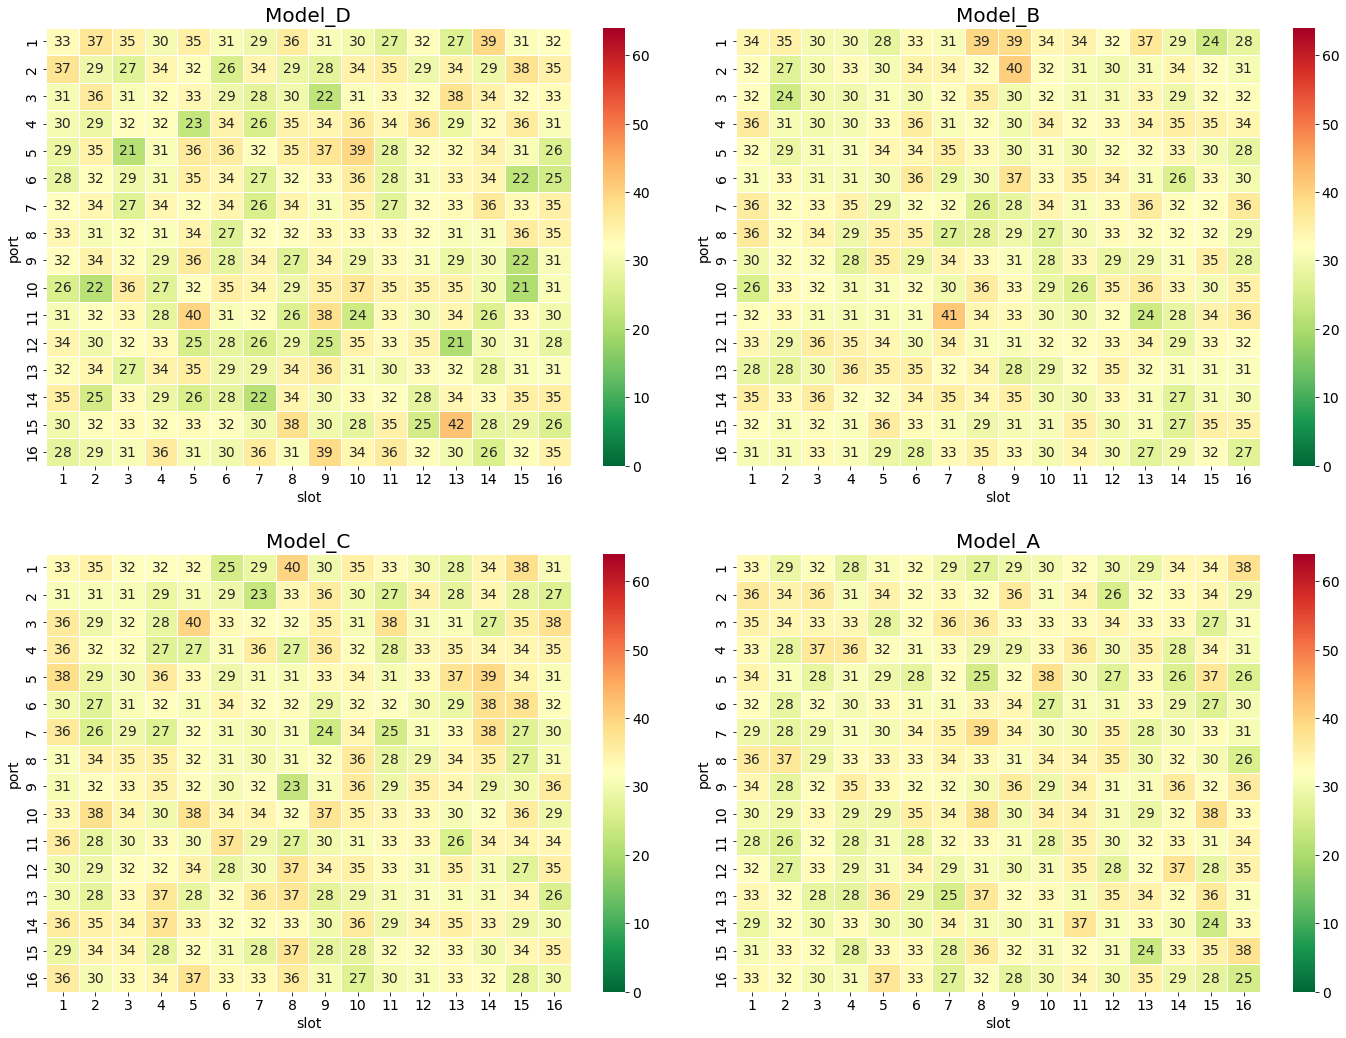

In [ ]:
plt.rcParams.update({'font.size':14, 'figure.figsize': (25,20)})

grouped_olts = concat_df.groupby(['port', 'slot', 'model'])['client_qty'].mean().reset_index()
grouped_olts.sort_values(by='model', inplace=True)

models = list(concat_df['model'].unique())
olts = []
for model in models:
    o =  grouped_olts[grouped_olts['model']==model]
    olts.append(o)

olt_list = []
for olt in olts:
    individual = olt.pivot(index='port', columns='slot', values='client_qty')
    olt_list.append(individual)


fig, axes = plt.subplots(2, 2, figsize=(20,15))
for (i, axs, olt, modelo) in zip(range(4), axes.flatten(), olt_list, models):
    sns.heatmap(olt, vmin=0, vmax=64, cmap='RdYlGn_r', linewidths=0.5, annot=True, ax=axs)
    axs.set_title(modelo, fontsize=20)
fig.tight_layout(pad=2)
plt.show()


## Closing comments

* Is evident that the mean value of the client quantity per PON port in this dataset obeys the "random.randint" function, but if you use it with your data it will surely reflect your networks KPIs.
* This visualization could give you unexpected insights because normaly we don't plot this kind of KPI in this format. for example:
    - You could see if overall your NEs have good distributed loads of clients among all the boards.
    - You could make this viz for every POP (point of presence), and check if particular POP is unbalanced,
    - And following the previous point, you could use this viz even per OLT, and check if a particular OLT is very loaded, and triggering a hypotetical client migration.
* This visualization can be generalized to represent router, switches, optical network equipments, etc., as long as the information is treated as showed.
* This visualization can also be about any KPI of the NE:
    - You could use the temperature of the PON port.
    - You could use the average/max/min PON port throughput.
* You could put this visualization in a dashboard, so by just applying a filter, you could check individual OLTs, or filter by country regions, states, network clusters, the posibilities are limitless.


I hope this was useful for you, and that you are looking forward for the next viz!